In [49]:
import numpy as np
from robot import RobotDescription
from da_test_suite_functions import *
from utils import *
import pandas as pd
from pytransform3d.transform_manager import *
import matplotlib.pyplot as plt
from acin_colors import acin_colors

In [34]:
########################### SETTINGS ###########################
# define which parameters are to be identified
parameter_id_masks = dict()
parameter_id_masks['theta'] =   [False, True, True, True, True, True, True, True]
parameter_id_masks['d'] =       [False, True, True, True, True, True, True, True]
parameter_id_masks['r'] =       [False, True, True, True, True, True, True, True]
parameter_id_masks['alpha'] =   [False, True, True, True, True, True, True, True]


# set scaling factor for error
factor = 10

# select observations file
observations_file_select = 0 

observations_file_str_dict = {0:  r'observation_files/ground_truth_dataset.p',
                              20: r'observation_files/obs_single_marker_2023-11-01-11-12-21_20240109-060457.p',
                              21: r'observation_files/observations_simulated_20240411_144805.p'
                              }
df_observations = pd.read_pickle(observations_file_str_dict[observations_file_select])



##########################################################################
# 1) Define robot parameters to be used
##########################################################################
# import nominal parameters
theta_nom = RobotDescription.dhparams["theta_nom"].astype(float)
d_nom = RobotDescription.dhparams["d_nom"].astype(float)
r_nom = RobotDescription.dhparams["r_nom"].astype(float)
alpha_nom = RobotDescription.dhparams["alpha_nom"].astype(float)
nominal_parameters = {'theta': theta_nom, 'd': d_nom, 'r': r_nom, 'alpha': alpha_nom}

# apply the errors - model the real robot
theta_error = apply_error_to_params(theta_nom, parameter_id_masks['theta'], factor, 'deg_to_rad')
d_error = apply_error_to_params(d_nom, parameter_id_masks['d'], factor, 'm_to_mm')
r_error = apply_error_to_params(r_nom, parameter_id_masks['r'], factor, 'm_to_mm')
alpha_error = apply_error_to_params(alpha_nom, parameter_id_masks['alpha'], factor, 'deg_to_rad')
error_parameters = {'theta': theta_error, 'd': d_error, 'r': r_error, 'alpha': alpha_error}


# apply the errors - model the real robot
factor = factor*0.1
theta_estd = apply_error_to_params(theta_nom, parameter_id_masks['theta'], factor, 'deg_to_rad')
d_estd = apply_error_to_params(d_nom, parameter_id_masks['d'], factor, 'm_to_mm')
r_estd = apply_error_to_params(r_nom, parameter_id_masks['r'], factor, 'm_to_mm')
alpha_estd = apply_error_to_params(alpha_nom, parameter_id_masks['alpha'], factor, 'deg_to_rad')
estd_parameters = {'theta': theta_estd, 'd': d_estd, 'r': r_estd, 'alpha': alpha_estd}

In [35]:
def get_joint_tfs_mod(q_vec, params):
    """
    modified version
    """
    joint_tfs = []  # initialize list
    q_vec = q_vec.flatten()
    q_vec = np.append(q_vec, np.zeros(RobotDescription.dhparams["num_cam_extrinsic"]))  # pad q vector with zero for non actuated last transform
    for (i, q) in enumerate(q_vec):  # iterate over joint values
        theta = params["theta"][i]
        d = params["d"][i]
        r = params["r"][i]
        alpha = params["alpha"][i]
        joint_tfs.append({'mat': RobotDescription.get_T_i_forward(q, theta, d, r, alpha),
                          'from_frame': str(i+1), 'to_frame': str(i)})

    joint_tfs.append({'mat': RobotDescription.T_W0, 'from_frame': '0', 'to_frame': 'world'})
    return joint_tfs


/home/armin/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


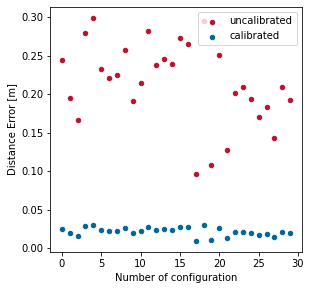

In [70]:
def plot_pose_errors_dist(nominal_parameters, error_parameters, estd_parameters, df_observations):
    # len of robot
    last_frame = RobotDescription.dhparams['num_cam_extrinsic'] + RobotDescription.dhparams['num_joints']
    
    # extract all qs from observations
    qs = np.vstack(df_observations['q'].to_numpy())
    qs_unique = np.unique(qs, axis=0)
    
    # create dataframe to store data
    data = pd.DataFrame()
    data['q'] = list(qs_unique)
    
    list_nom_positions = []
    list_err_positions = []
    list_est_positions = []
    
    for q in data['q']:
        # get camera poses nominal
        joint_tfs = get_joint_tfs_mod(q, nominal_parameters)
        tm = TransformManager()
        for tf in joint_tfs:
            from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
            tm.add_transform(from_frame, to_frame, A2B)
        list_nom_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3,3])


        # get camera poses error
        joint_tfs = get_joint_tfs_mod(q, error_parameters)
        tm = TransformManager()
        for tf in joint_tfs:
            from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
            tm.add_transform(from_frame, to_frame, A2B)
        list_err_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3,3])

        # get camera poses identified
        joint_tfs = get_joint_tfs_mod(q, estd_parameters)
        tm = TransformManager()
        for tf in joint_tfs:
            from_frame, to_frame, A2B = tf['from_frame'], tf['to_frame'], tf['mat']
            tm.add_transform(from_frame, to_frame, A2B)
        list_est_positions.append(np.array(tm.get_transform(str(last_frame), 'world'))[0:3,3])
    
    data['nominal'] = list_nom_positions
    data['error'] = list_err_positions
    data['estd'] = list_est_positions
    
    # calculate the distances
    data['dist_err'] = data['nominal']-data['error']
    data['dist_err'] = data['dist_err'].apply(np.linalg.norm)
    #print(data['dist_err'][0])

    data['dist_est'] = data['nominal']-data['estd']
    data['dist_est'] = data['dist_est'].apply(np.linalg.norm)
    #print(data['dist_est'][0])
    
    data['index'] = data.index
    
    fig, ax = plt.subplots(1,1, figsize=(4.5,4.5))
    data.plot.scatter(ax=ax, x='index', y='dist_err', color=acin_colors['red'])
    data.plot.scatter(ax=ax, x='index', y='dist_est', color=acin_colors['blue'])
    ax.set_xlabel('Number of configuration')
    ax.set_ylabel('Distance Error [m]')

    ax.legend(['uncalibrated', 'calibrated'], loc='upper right')
    
    
plot_pose_errors_dist(nominal_parameters, error_parameters, estd_parameters, df_observations)

In [76]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

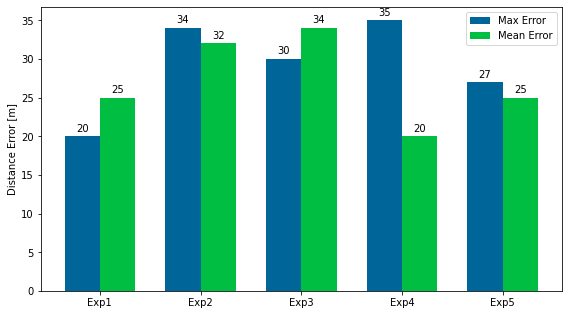

In [78]:

labels = ['Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5']
err_max = [20, 34, 30, 35, 27]
err_mean = [25, 32, 34, 20, 25]

            
def plot_pose_errors_bar(labels, err_max, err_mean):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,4.5))
    rects1 = ax.bar(x - width/2, err_max, width, label='Max Error', color=acin_colors['blue'])
    rects2 = ax.bar(x + width/2, err_mean, width, label='Mean Error', color=acin_colors['green'])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distance Error [m]')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1, ax)
    autolabel(rects2, ax)

    fig.tight_layout()
    
plot_pose_errors_bar(labels, err_max, err_mean)

In [105]:
# import trajectory
traj_file="/home/armin/catkin_ws/src/kident2/src/traj.csv"
try:
    df = pd.read_csv(traj_file)
except Exception as e:
    print(e)
traj = df.to_numpy()  # shape: (num_joints, num_traj_points)
traj = traj[:, 1:]  # delete header

traj_deg = traj/np.pi*180
traj_id = list(range(len(traj_deg.T)))
# for pair in enumerate(traj):
#     print(f"{pair[0]}:{pair[1]}")
    
# print(list(range(len(traj))))

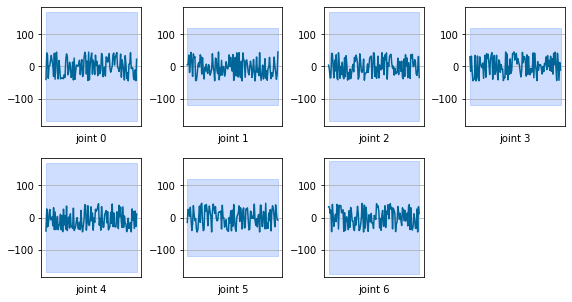

In [108]:
j_lims={}
j_lims[1]={ "lower":    -170
            ,"upper":    170
            ,"effort":   320
            ,"vel":      1.4835
            }
j_lims[2]={ "lower":    -120
            ,"upper":    120
            ,"effort":   320
            ,"vel":      1.4835
            }
j_lims[3]={ "lower":    -170
            ,"upper":    170
            ,"effort":   176
            ,"vel":      1.7453
            }
j_lims[4]={ "lower":    -120
            ,"upper":    120
            ,"effort":   176
            ,"vel":      1.3090
            }
j_lims[5]={ "lower":    -170
            ,"upper":    170
            ,"effort":   110
            ,"vel":      2.2689
            }
j_lims[6]={ "lower":    -120
            ,"upper":    120
            ,"effort":   40
            ,"vel":      2.3562
            }
j_lims[7]={ "lower":    -175
            ,"upper":    175
            ,"effort":   40
            ,"vel":      2.3562
            }

def plot_with_joint_limits(joints, time):
    fig, axs = plt.subplots(2,4, figsize=(8, 4.5))
    fig.suptitle('')
    fig.tight_layout()
    for i, ax in enumerate(list(axs.flatten())[:-1]):
        ax.fill_between(time, [j_lims[i+1]["lower"]], [j_lims[i+1]["upper"]], color=acin_colors['blue_variant'], alpha=0.2)
        ax.plot(time, joints[i,:], color=acin_colors['blue'])
        ax.set_ylim([-185, 185])
        ax.set_xlabel(f"joint {i}")
        ax.set_xticks([])
        ax.grid(which='both')
    list(axs.flatten())[-1].axis('off')

plot_with_joint_limits(traj_deg, traj_id)